In [1]:
!! pip install pandas_plink
from pandas_plink import read_plink
import pandas_plink as pdplink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Merge All Data With Prof Data

Combine all the chromosome files together

```
plink --bfile LDREF/1000G.EUR.1 --merge-list merge_list.txt --make-bed --out 1000G_combined
```
Merge with Prof Data
```
plink --bfile 1000G_combined --bmerge Tiffany.bed Tiffany.bim Tiffany.fam --make-bed --out combined_with_Tiffany
```
Got an error message in plink for that there are mismatching SNPs, so I exclude them to do basically a inner merge in the next step

Filter Big file to not include mismatching SNPs
```
plink --bfile 1000G_combined --exclude combined_with_Tiffany-merge.missnp --make-bed --out new_merge
```
Merge with Prof Data Again
```
plink --bfile new_merge --bmerge Tiffany.bed Tiffany.bim Tiffany.fam --make-bed --out final_combined
```

# Step 2: Get Summary Stats for the different diseases

I defined a function for preparing th summary statistics for PRS but I had to prepare them individually since each summary statistics file was formatted differently, and different preparation steps needed to be taken.


In [ ]:
# Read in the GWAS summary statistics and rename them to fit stats
def prepare_summary_stats_for_prs(input_file_name, output_file_name):
  """
  input_file_name: Height.gwas.txt
  output_file_name: Height.formatted.gwas.txt
  """
  gwas_summary = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/{input_file_name}', sep='\t')
  prs_data = gwas_summary[['SNP', 'A1', 'OR']].copy()
  prs_data.columns = ['SNP', 'ALLELE', 'BETA']
  prs_data.to_csv(f'/content/drive/My Drive/Colab Notebooks/{output_file_name}', sep=' ', index=False)


In [ ]:
# alzhiemers
gwas_summary = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/alz_data.txt', sep=' ')
prs_data = gwas_summary[['SNP', 'A1', 'BETA']].copy()
prs_data.columns = ['SNP', 'ALLELE', 'BETA']
prs_data

In [ ]:
prs_data.to_csv(f'/content/drive/My Drive/Colab Notebooks/alz_data.gwas.txt', sep=' ', index=False)

In [ ]:
# megastroke
gwas_summary_megastroke = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/megastroke.txt', sep=' ')
prs_data = gwas_summary_megastroke[['MarkerName', 'Allele1', 'Effect']].copy()
prs_data.columns = ['SNP', 'ALLELE', 'BETA']
prs_data['ALLELE'] = prs_data['ALLELE'].str.upper()
prs_data

In [ ]:
prs_data.to_csv(f'/content/drive/My Drive/Colab Notebooks/megastroke.gwas.txt', sep=' ', index=False)

In [ ]:
prepare_summary_stats_for_prs("alz_data.txt", "alz_data.gwas.txt")

In [2]:
# bone density
import gzip
delimiter = '\t'
with gzip.open('/content/drive/My Drive/Colab Notebooks/bone.gz', 'rt') as file:
    df = pd.read_csv(file, delimiter=delimiter)

In [3]:
df

,chromosome,position,rs_number,reference_allele,other_allele,eaf,beta,se,beta_95L,beta_95U,z,p-value,_-log10_p-value,q_statistic,q_p-value,i2,n_studies,n_samples,effects
0,1,12775981,chr1:12775981,G,T,0.955927,-0.004616,0.020309,-0.044421,0.035189,-0.227291,0.823541,0.084315,2.672359,0.988119,0.000000,11,-9,-???+-+-+---+-
1,1,12776140,chr1:12776140,C,T,0.997375,0.141407,0.252268,-0.353039,0.635853,0.560542,0.582401,0.234778,0.349061,0.839851,0.000000,3,-9,+????+?+??????
2,1,12776161,chr1:12776161,G,A,0.965792,0.004070,0.020369,-0.035853,0.043992,0.199799,0.844588,0.073355,2.252773,0.994010,0.000000,11,-9,+???+-+-+---+-
3,1,12776218,chr1:12776218,A,C,0.133095,-0.002270,0.011081,-0.023987,0.019448,-0.204824,0.840733,0.075342,30.408288,0.000734,0.671142,11,-9,-???----+-++++
4,1,12776441,chr1:12776441,C,T,0.999364,0.114381,0.186730,-0.251611,0.480372,0.612545,0.547907,0.261293,3.315318,0.506509,0.000000,5,-9,+???-+?+?-????
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10586894,22,45377988,chr22:45377988,A,G,0.000557,0.108969,0.106263,-0.099305,0.317244,1.025471,0.315659,0.500782,0.157364,0.691595,0.000000,2,-9,?????+?+?
10586895,22,48248686,chr22:48248686,C,G,0.000557,0.135522,0.095891,-0.052424,0.323468,1.413295,0.166690,0.778090,0.578366,0.446954,0.000000,2,-9,?????+?+?
10586896,22,48381151,rs191016838,C,T,0.000557,-0.051695,0.063512,-0.176178,0.072788,-0.813942,0.425795,0.370799,0.621733,0.430404,0.000000,2,-9,?????-?-?
10586897,22,49007288,chr22:49007288,A,G,0.000318,-0.055287,0.094962,-0.241411,0.130838,-0.582198,0.568929,0.244942,0.396661,0.528819,0.000000,2,-9,?????-?-?


In [4]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/megastroke.txt', sep='\t', index=False)

In [ ]:
prs_data = df[['rs_number', 'reference_allele', 'beta']].copy()
prs_data.columns = ['SNP', 'ALLELE', 'BETA']
prs_data['ALLELE'] = prs_data['ALLELE'].str.upper()
prs_data

,SNP,ALLELE,BETA
0,chr1:12775981,G,-0.004616
1,chr1:12776140,C,0.141407
2,chr1:12776161,G,0.004070
3,chr1:12776218,A,-0.002270
4,chr1:12776441,C,0.114381
...,...,...,...
10586894,chr22:45377988,A,0.108969
10586895,chr22:48248686,C,0.135522
10586896,rs191016838,C,-0.051695
10586897,chr22:49007288,A,-0.055287


In [ ]:
prs_data.to_csv(f'/content/drive/My Drive/Colab Notebooks/bone.gwas.txt', sep=' ', index=False)

Plink Commands for Generating PRS Scores for each of the Traits



```
plink --bfile final_combined --score alz_data.gwas.txt 1 2 3 --out prs_for_alz
```

```
plink --bfile final_combined --score megastroke.gwas.txt 1 2 3 --out prs_for_mgs
```



```
plink --bfile final_combined --score bone.gwas.txt 1 2 3 --out prs_for_bone
```


In [ ]:
prs_data = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/prs_for_alz.profile', delim_whitespace=True)
prs_data.head()

,FID,IID,PHENO,CNT,CNT2,SCORE
0,HG00096,HG00096,-9,2184470,1046678,-0.000025
1,HG00097,HG00097,-9,2184470,1046342,-0.000014
2,HG00099,HG00099,-9,2184470,1046513,-0.000030
3,HG00101,HG00101,-9,2184470,1046466,0.000002
4,HG00102,HG00102,-9,2184470,1047292,-0.000030


# Step 3: Plot the Distributions

In [ ]:
#plot data
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prs_dist(prfile_file_name, trait):
  prs_data = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/{prfile_file_name}.profile', delim_whitespace=True)
  prs_data.head()
  # plot the distribution
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.histplot(prs_data['SCORE'], kde=True, color="skyblue", bins=30)
  plt.title(f'Distribution of PRS for {trait}')
  plt.xlabel('Polygenic Risk Score')
  plt.ylabel('Frequency')

  tiffany_prs = prs_data[prs_data['IID'] == 'Tiffany']['SCORE'].iloc[0]
  plt.axvline(tiffany_prs, color='red', linestyle='dashed', linewidth=2)
  plt.text(tiffany_prs, plt.ylim()[1]*0.9, 'Tiffany', color = 'red')

  # Show
  plt.legend(['1KG Individuals', 'Tiffany'])
  plt.show()

  from scipy import stats
  tiffany_prs = prs_data[prs_data['IID'] == 'Tiffany']['SCORE'].iloc[0]
  percentile = stats.percentileofscore(prs_data['SCORE'], tiffany_prs)
  print(percentile)
  return percentile

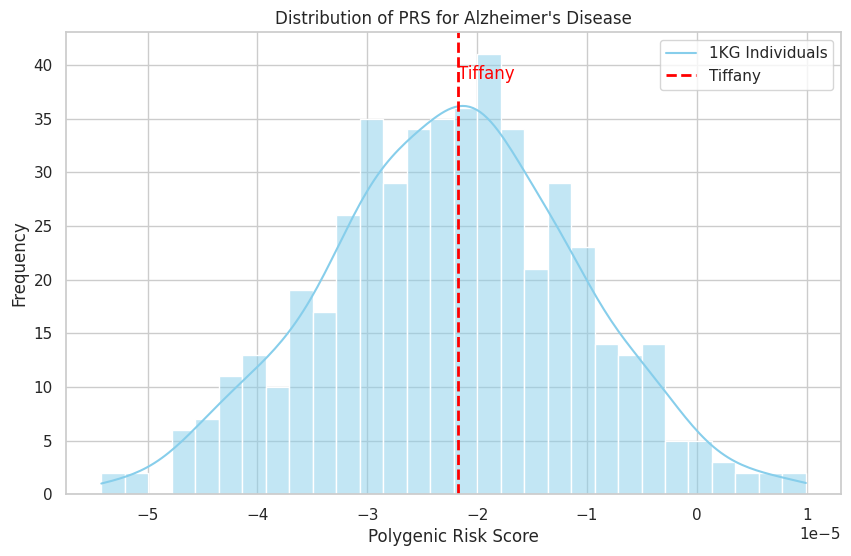

51.83673469387755


In [ ]:
plot_prs_dist("prs_for_alz", "Alzheimer's Disease")

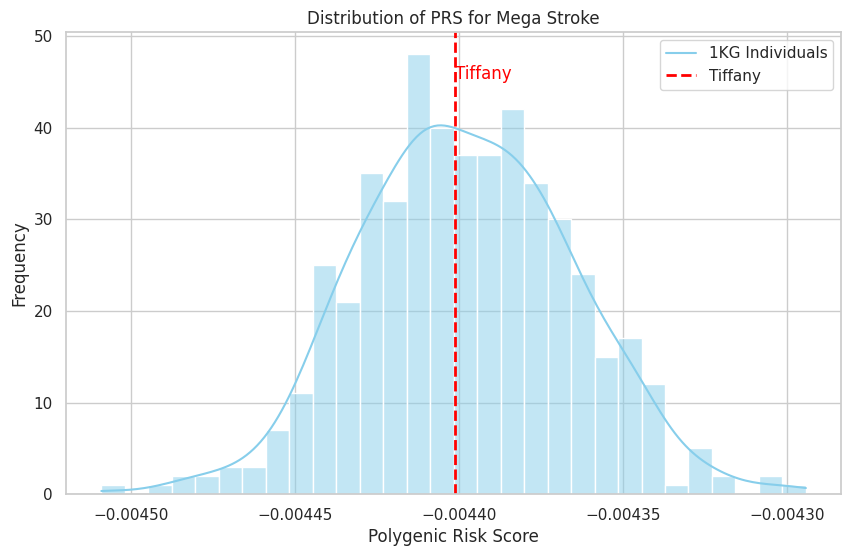

48.36734693877551


In [ ]:
plot_prs_dist("prs_for_mgs", "Mega Stroke")

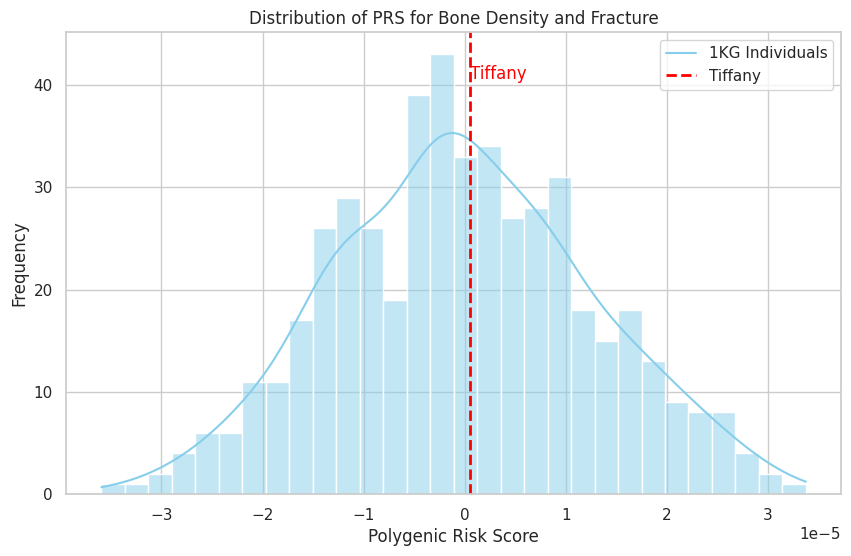

54.285714285714285


In [ ]:
plot_prs_dist("prs_for_bone", "Bone Density and Fracture")